In [3]:
%matplotlib inline
#
from lrgsglib.core import *
# from lrgsglib.Ccore.statsys.RBIsingM.storer import ising_model_store
move_to_rootf()
plt.style.use('ipynb/nb_plotsheet.mplstyle')
#
datpath = os.path.join('data')
Isingdatapath = os.path.join(datpath, 'devTools', 'RBIsingM')
plotpath = os.path.join(Isingdatapath, 'plot')
clusterdatapath = os.path.join('cluster_data', 'cluster_data_ising')
os.makedirs(plotpath, exist_ok=True)

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


In [5]:
from sklearn.datasets import fetch_openml
# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float32)
y = mnist.target.astype(np.int64)

In [239]:
indices = np.where(y == 8)[0]
X_digit = X.iloc[indices][:1] # Use .iloc to index rows correctly
patterns = X_digit.values  # Convert row to numpy array
patterns = np.where(patterns > 127, 1, -1)

In [267]:
lattice = Lattice2D(28, pflip=0.1, geo='sqr', init_nw_dict=True)
# lattice.flip_sel_edges(lattice.nwDict['rand']['G'])
lattice.compute_full_laplacian_spectrum()

In [268]:
num = lattice.N

In [269]:
basis = lattice.get_eigV_bin_check_list(slice(0, num))
coeff = np.zeros(num-1)
for i,pattern in enumerate(patterns):
    coeff += matrix_projection(pattern, basis)
coeff /= len(patterns)

In [261]:
imgv = reconstruct_from_projections(coeff, lattice.get_eigV_bin_check_list(slice(0, num)))

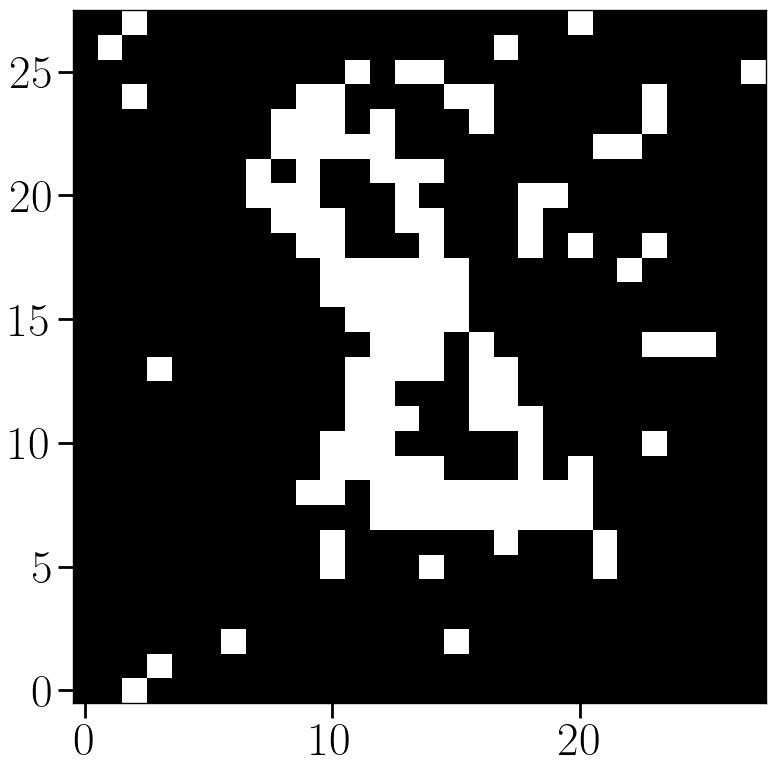

In [263]:
plt.imshow(np.sign(imgv).reshape(28, 28), cmap='gray')

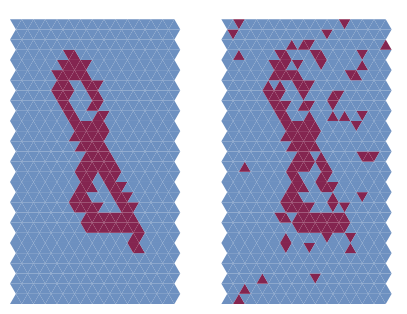

In [266]:
data = patterns[0].reshape(28, 28)
fig, ax = plt.subplots(ncols=2, figsize=(5, 5))
plot_honeycomb_grid(data, fig, ax[0])
data = np.sign(imgv).reshape(28, 28)
plot_honeycomb_grid(data, fig, ax[1])

### Zero temperature stability C5 test

In [2]:
lattice = Lattice2D(48, pflip=0.3, init_nw_dict=True, seed=10, )
lattice.flip_sel_edges(lattice.nwDict['randXERR']['G'])
lattice.compute_k_eigvV()

In [12]:
isdy = IsingDynamics(lattice, T=0., ic=f'custom', runlang="C5", rndStr=True)
isdy.init_ising_dynamics(custom=sout[-1])
lattice.export_edgel_bin(exName=isdy.id_string_isingdyn)

In [13]:
isdy.run(verbose=True, thrmSTEP=10)

Executing:  src/lrgsglib/Ccore/bin/IsingSimulator5 2304 0 0.3 10 20 data/l2d_squared N=2304 _vwCX7QQ4lS  asynchronous 10

In [14]:
ene = np.fromfile(lattice.path_ising / 'ene_p=0.3_T=0__vwCX7QQ4lS_.bin')
sout = np.fromfile(lattice.path_ising / 'sout_p=0.3_T=0__vwCX7QQ4lS_.bin', dtype=np.int8).reshape(-1, *lattice.syshape)

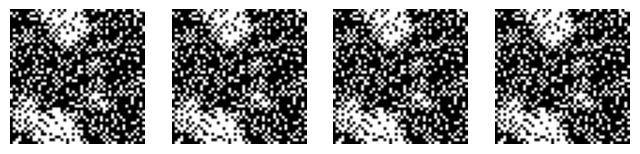

In [15]:
fig, ax = plt.subplots(1, len(sout), figsize=(8, 8*len(sout)))
for i, s in enumerate(sout):
    ax[i].imshow(s, cmap='gray')
    ax[i].axis('off')

In [18]:
compute_delta_energies(sout[-1].flatten(), lattice.gr['G'].edges(data='weight')) > 0

False

-3908.0
-3744.0
-3788.0
-3764.0


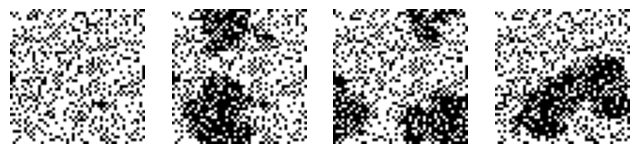

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(8, 8*4))
for i in range(4):
    ax[i].imshow(lattice.get_eigV_bin_check(i).reshape(*lattice.syshape), cmap='gray')
    ax[i].axis('off')
    print(lattice.get_rbim_energy_eigV(i))

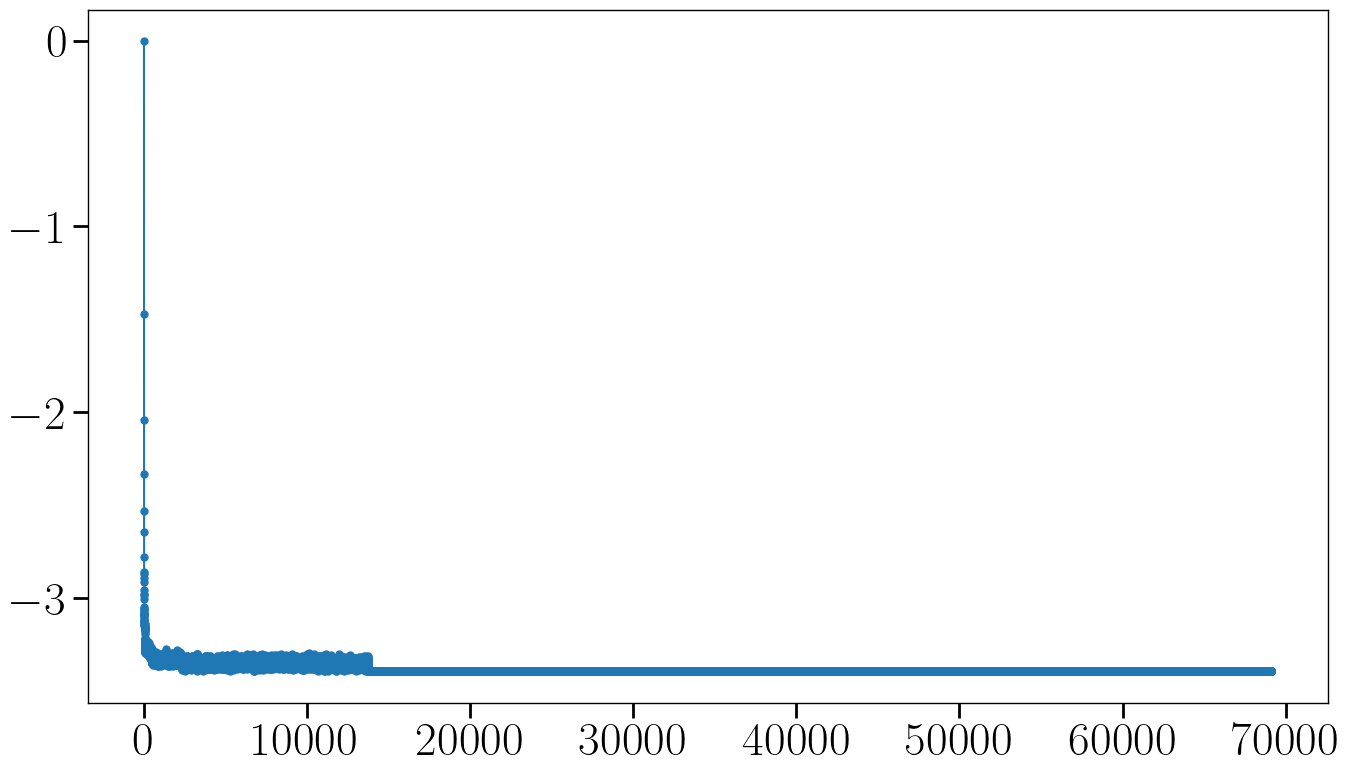

In [22]:
plt.plot(ene)

### C4 overlap test

In [2]:
lengc = 0
number = 2
while lengc < 0.33:
    seedsave = np.random.randint(0, 2**32-1)
    lattice = Lattice2D(48, pflip=0.3, init_nw_dict=True, seed=seedsave)
    lattice.flip_sel_edges(lattice.nwDict['randXERR']['G'])
    lattice.compute_k_eigvV(number+1)
    lattice.load_eigV_on_graph(number, binarize=True)
    lattice.make_clustersYN(f"eigV{number}", val=-1)
    lengc = len(lattice.gc)/lattice.N

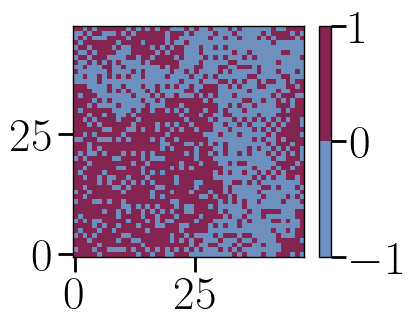

In [9]:
plt.figure(figsize=(4, 3))
plt.imshow(lattice.get_eigV_bin_check(number).reshape(*lattice.syshape), interpolation='none', cmap=credcblu)
plt.colorbar()

In [4]:
isdy = IsingDynamics(lattice, T=1., ic=f'ground_state_{number}', runlang="C4", rndStr=True)
isdy.init_ising_dynamics()
print(isdy.id_string_isingdyn)
lattice.export_eigV(number, exName=isdy.id_string_isingdyn)
lattice.export_edgel_bin(exName=isdy.id_string_isingdyn)
print(isdy.id_string_isingdyn)
isdy.export_ising_clust(which=1, val=-1)


nTGVc0Ht9H
nTGVc0Ht9H


In [5]:
print(isdy.id_string_isingdyn)

isdy.run(verbose=True, thrmSTEP=100)

nTGVc0Ht9H
Executing:  src/lrgsglib/Ccore/bin/IsingSimulator4 2304 1 0.3 1 100 20 data/l2d_squared N=2304 _nTGVc0Ht9H  asynchronous 10 2

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(lattice.get_eigV_bin_check(2).reshape(*lattice.syshape))
ax[1].imshow(isdy.s.reshape(*lattice.syshape))

In [ ]:
np.sum(isdy.s.reshape(*lattice.syshape)-lattice.get_eigV_bin_check(2).reshape(*lattice.syshape) == 0)/lattice.N

In [64]:
coords = list(itemgetter(*list(isdy.sg.biggestClSet[0]))(lattice.nodeMap['H']['G']))
array = np.zeros((32, 32), dtype=int)

# Set entries in coords to +1
for x, y in coords:
    array[x, y] = 1

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(isdy.s_0.reshape(*lattice.syshape), cmap='binary', origin='lower')
ax1.imshow(array, cmap=cmap_rb)
ax2.imshow(isdy.s.reshape(*lattice.syshape), cmap='binary', origin='lower')
ax2.imshow(array, cmap=cmap_rb)

In [ ]:
import matplotlib.colors


c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
c_black= matplotlib.colors.colorConverter.to_rgba('red',alpha = 1)
cmap_rb = matplotlib.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_black,c_white],512)


cmap_rb

## Ising dynamics over signed graphs

### LAttice2D

In [ ]:
side=64
pflip = 0.25
T = 0.5
remove_files = True
eig_init = 2

In [ ]:
l = Lattice2D(side1=side, pflip=pflip, dataOut=Isingdatapath, init_nw_dict=True)
l.flip_sel_edges(l.nwDict['randXERR']['G'])
# l.compute_k_eigvV(howmany=eig_init+1)
isdy = IsingDynamics(l, T=T, ic=f'ground_state_2', runlang='C1', rndStr=True)
isdy.init_ising_dynamics()
l.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust(which=1)
# if remove_files:
#     isdy.remove_run_c_files(remove_stderr=True)
#     er.remove_edgl_file()

In [ ]:
isdy.run(verbose=False, thrmSTEP=50)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im = ax[1].imshow(isdy.s.reshape(*l.syshape))
plt.colorbar(im)
im = ax[0].imshow(l.get_eigV_bin_check(2).reshape(*l.syshape))
plt.colorbar(im)

### Erdos-Renyi

In [ ]:
n = 400
p = 8/n
pflip = 0.2
T = 2
remove_files = True
eig_init = 2

In [ ]:
er = ErdosRenyi(n=n, p=p, pflip=pflip, dataOut=Isingdatapath, init_nw_dict=True)
er.flip_sel_edges(er.nwDict['randXERR']['G'])
er.compute_k_eigvV(howmany=eig_init+1)
isdy = IsingDynamics(er, T=T, ic=f'ground_state_2', runlang='C1', rndStr=True)
isdy.init_ising_dynamics()
er.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust(which=2)
# if remove_files:
#     isdy.remove_run_c_files(remove_stderr=True)
#     er.remove_edgl_file()

In [ ]:
isdy.run(verbose=False)

In [ ]:
nx.draw(er.G, node_color=isdy.s, edge_color=er.get_edge_color())

In [ ]:
nx.draw(er.G, node_color=-np.sign(er.eigV[2]))

## OLD

In [ ]:
size = 1024
k = 10
p = k/size
pflip = 0.01

In [ ]:
er = ErdosRenyi(20000, p, pflip=0.5)
er.flip_random_fract_edges()
er.compute_k_eigvV()

In [ ]:
min(np.abs(er.eigV[0]))

In [ ]:
N = 0
while N != size:
    er = ErdosRenyi(size, p, pflip=pflip, init_nw_dict=True)
    N = er.N

In [ ]:
size = 64
for i,pflip in enumerate([0.1, 0.45]):
    er = Lattice2D(size, pflip=pflip)
    er.flip_random_fract_edges()
    # er.compute_k_eigvV()
    # er.flip_sel_edges(list(set(er.nwDict['randXERR']['G'])))
    # er.export_edgel_bin()
    er.compute_k_eigvV(MODE_dynspec='numpy')
    # er.load_eigV_on_g(binarize=True)
    # er.make_clustersYN(f'eigV0', +1)
    plt.hist(er.eigv, bins=60, density=True)
plt.yscale('log')

In [ ]:
e = ((7, 24),(6, 25))
tuple(sorted(e))

In [ ]:
for size in [100, 500, 1000, 2000]:
    er = ErdosRenyi(size, p, pflip=0.4)
    er.flip_random_fract_edges()
    # er.compute_k_eigvV()
    # er.flip_sel_edges(list(set(er.nwDict['randXERR']['G'])))
    # er.export_edgel_bin()
    er.compute_k_eigvV(MODE_dynspec='numpy')
    # er.load_eigV_on_g(binarize=True)
    # er.make_clustersYN(f'eigV0', +1)
    plt.hist(er.eigv, bins=80, density=True)
plt.yscale('log')

In [ ]:
isi = IsingDynamics(er, T=10, ic='ground_state_0', runlang="C1", NoClust=1)
isi.init_ising_dynamics()
isi.export_s_init()
isi.export_ising_clust()
isi.run(eqSTEP=50)

In [ ]:
nx.draw(er.G, edge_color=er.get_edge_color(), node_size=10)

In [ ]:
er.flip_random_fract_edges()


In [ ]:
isi = IsingDynamics(er, T=0., ic='uniform', runlang="C3", NoClust=1)
isi.init_ising_dynamics()
isi.export_s_init()
isi.export_ising_clust()
isi.run(eqSTEP=50)

In [ ]:
ene = np.fromfile(os.path.join(er.isingpath, 'ene_p=0.35_T=0_.bin'), dtype=np.float64)

In [ ]:
plt.plot(-np.abs(ene))
plt.yscale('symlog')
plt.xscale('symlog')

In [ ]:
isi.s

In [ ]:
er.G

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
nx.draw(er.G, ax=ax)

In [ ]:
cmap = restr_twilight#
colors = cmap(np.linspace(0, 1, len(eneT)))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)
plt.plot(eneT[0], c='r')
for e in eneT[1:]:
    plt.plot(e)
plt.xscale('symlog')

In [ ]:
nx.draw(er.G, cmap=restr_twilight,
        edge_color=er.get_edge_color(), 
        node_color=np.sign(er.eigV[0]), with_labels = True)

In [ ]:
l = Lattice2D(10, pflip=0.1, init_nw_dict=True)
l.compute_k_eigvV()
l.export_edgel_bin()
#
isi = IsingDynamics(l, T=0.5, ic='ground_state_0', runlang="C3", NoClust=1)

In [ ]:
isi.sg.datPath

In [ ]:
cell = 'rand'
pflip = 0.2
side = 64
T = 0.5

In [ ]:
l = Lattice2D(side, pflip=pflip, init_nw_dict=True)
l.flip_sel_edges(l.nwDict[cell]['G'])
l.compute_k_eigvV()
l.export_edgel_bin()
#
isi = IsingDynamics(l, T=T, ic='ground_state_0', runlang="C3", NoClust=1)
isi.init_ising_dynamics()
isi.export_s_init()
isi.run(eqSTEP=50)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(np.sign(l.eigV[0].reshape(l.syshape)), cmap='gray', origin='lower')
ax1.imshow(isi.s.reshape(l.syshape), cmap='gray', origin='lower')

In [ ]:
plt.imshow(isi.s.reshape(side, side), cmap='hot')
plt.axis('off')
plt.savefig(os.path.join(plotpath, 'ising_rand_128_0.25_0.1.pdf'), bbox_inches='tight')

In [ ]:
cell = 'randXERR'
pflip = 0.45
side = 64
T = 0.1

In [ ]:
l = Lattice2D(side, pflip=pflip, init_nw_dict=True)
l.flip_sel_edges(l.nwDict[cell]['G'])
l.compute_k_eigvV()
l.export_edgel_bin()
#
isi = IsingDynamics(l, T=T, ic='ground_state_0', runlang="C3", NoClust=1)
isi.init_ising_dynamics()
isi.export_s_init()
isi.run()


In [ ]:
plt.imshow(isi.s.reshape(*l.syshape))

In [ ]:
x, pdf = powerlaw.pdf(np.abs(l.eigV[0]))
plt.loglog(x[1:], pdf)


In [ ]:
isi.export_ising_clust()

In [ ]:
a = l.eigV[0]

In [ ]:
l.biggestClSet[0]

In [ ]:
a[np.array(list(l.biggestClSet[3]))] = 0

In [ ]:
plt.imshow(np.sign(a.reshape(*l.syshape)))

In [ ]:
91/48

In [ ]:
list(l.biggestClSet[0])

## minfinito

In [ ]:
sizes = [16, 32, 64]
sffx = 'gs0_X'
l = Lattice2D(side1=sizes[-2], sgpath=clusterdatapath)

In [ ]:
def interpolate_data(P, T, variances, num_points=1000):
    """
    Interpolates the data over a grid of specified density.
    P, T are meshgrids of p and T values.
    variances is the matrix of computed variances.
    num_points is how dense the new grid should be.
    """
    # Create the points where we have data
    points = np.array([P.flatten(), T.flatten()]).T
    values = variances.flatten()

    # Create a grid where we want to interpolate
    p_new = np.linspace(P.min(), P.max(), num_points)
    t_new = np.linspace(T.min(), T.max(), num_points)
    P_new, T_new = np.meshgrid(p_new, t_new)

    # Interpolate using linear or cubic interpolation
    variances_new = griddata(points, values, (P_new, T_new), method='cubic', fill_value=np.nan)

    return P_new, T_new, variances_new
def gen_valid_lines(filename):
    """ Generator that yields only valid lines with exactly two numeric entries. """
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:  # Only yield lines with exactly two numeric entries
                try:
                    # Convert to float to ensure they are numeric
                    float(parts[0]), float(parts[1])
                    yield line
                except ValueError:
                    continue  # Skip lines that cannot be converted to float
def read_and_compute_variance(filepath):
    """ Reads a two-column file and computes the variance of the first column. """
    data = np.loadtxt(gen_valid_lines(filepath))
    mask = np.abs(data) <= 1
    filtered_array = data[mask]
    return np.mean(np.abs(filtered_array))
def prepare_data_for_plotting(search_dir):
    filenames = os.listdir(search_dir)
    p_values = set(extract_values_from_filenames(filenames, r"p=([\d.]+)"))
    T_values = set(extract_values_from_filenames(filenames, r"T=([\d.]+)"))
    
    # Create a meshgrid for p and T
    P, T = np.meshgrid(sorted(p_values), sorted(T_values))
    variance_matrix = np.zeros(P.shape)
    
    # Map filenames to their p and T values
    file_map = {}
    for filename in filenames:
        p = float(re.search(r"p=([\d.]+)", filename).group(1))
        t = float(re.search(r"T=([\d.]+)", filename).group(1))
        file_map[(p, t)] = filename

    # Compute variance for each p, T combination
    for (i, j), p in np.ndenumerate(P):
        t = T[i, j]
        filepath = os.path.join(search_dir, file_map.get((p, t)))
        if filepath:
            variance_matrix[i, j] = read_and_compute_variance(filepath)
    
    return P, T, variance_matrix

def plot_surface(P, T, variances, elev=10, azim=40, T_value=2.2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(P, T, variances, cmap=restr_twilight, edgecolor='k', lw=0.2)
    clb = fig.colorbar(surf, ax=ax, pad=0, shrink=0.8)
    # fig.colorbar(surf, ax=ax, label=r'$\avg*{m_{\infty}^{\mathrm{GC}}}$')
    ax.set_xlabel('$p$', labelpad=30)
    ax.set_ylabel('$T$', labelpad=30)
    ax.set_zlim(0, 1)
    ax.zaxis.set_tick_params(pad=15)  # Increase pad to move labels away from the axis
    intersection_z = variances[T == T_value]
    ax.scatter(P[T == T_value], np.full_like(intersection_z, T_value), intersection_z, color='black')


    ax.set_title(r'$\avg*{m_{\infty}^{\mathrm{GC}}}$')
    ax.view_init(elev=elev, azim=azim)
    fig.tight_layout()
    return fig, ax



In [ ]:
# Assuming the directory path is stored in `isingpath`
P, T, variances = prepare_data_for_plotting(l.isingpath)
P_new, T_new, variances_new = interpolate_data(P, T, variances)

fig, ax = plot_surface(P_new, T_new, variances_new)
fig.savefig(os.path.join(plotpath, 'variance_surface.png'), dpi=300)

In [ ]:
side =32
geo = 'squared'
cell = 'randXERR'
p = 0.2
howmany=2
number=0
T=0.1

In [ ]:
for i in range(100):
    while True:
        l = Lattice2D(side, geo, sgpath='devTools', pflip=p, init_nw_dict=True, seed=random.randint(0, 1000000))
        l.flip_sel_edges(l.nwDict[cell]['G'])
        l.compute_k_eigvV(howmany=number + 1)
        l.load_eigV_on_graph(which=number, binarize=True)
        l.make_clustersYN(f'eigV{number}', +1)
        print(l.N, len(l.gc))
        if  abs(l.gcBinLen/l.N - meanN) < stdN:
            break
        isdy = IsingDynamics(l, T, ic="ground_state_0", runlang="C1", NoClust=1, 
                            rndStr=True, out_suffix='test', 
                            id_string='test')
        isdy.init_ising_dynamics()
        l.export_edgel_bin(exName=isdy.id_string_isingdyn)
        isdy.export_ising_clust()
        isdy.run(verbose=False)

### Ising overlap giant cluster $\langle m_\infty\rangle$

In [ ]:
side = 32
geo = 'squared'
pflip = 0.25
gsN = 0
NoClust = 1
cell = 'randXERR'
ic = 'ground_state_0'
in_suffix = f"{cell}"
out_suffix = f"{cell}_testC1"
runlang = 'C1'
navg_def = 10
T_0 = 0.1
T_F = 3
numT = 20
Tlist = np.linspace(T_0, T_F, numT)

In [ ]:
for T in Tlist:
    for navg in range(navg_def):
        l = Lattice2D(side1=side, sgpath=Isingdatapath, geo=geo, pflip=pflip,
                    init_nw_dict=True)
        l.flip_sel_edges(l.nwDict[cell]['G'])
        l.compute_k_eigvV(howmany=gsN+1)
        # baseName = f"outcl{gsN}_p={pflip:.3g}_T={T:.3g}_{out_suffix}.txt"
        # if os.path.exists(os.path.join(l.isingpath, baseName)):
        #     continue
        isdy = IsingDynamics(l, T, ic=ic, runlang=runlang, NoClust=NoClust, 
                             rndStr=True, out_suffix=out_suffix,
                             id_string=in_suffix)
        isdy.init_ising_dynamics()
        isdy.export_ising_clust()
        l.export_edgel_bin(exName=isdy.id_string_isingdyn)
        isdy.run(verbose=True)
        isdy.remove_run_c_files()
        l.remove_edgl_file()

In [ ]:
path = l.isingpath
baseName = lambda t: f"outcl{gsN}_p={pflip:.3g}_T={t:.3g}_{out_suffix}.txt"
dat = {T: np.loadtxt(fname)
       for T in Tlist if os.path.exists(
           fname := os.path.join(path, baseName(T)))}

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
#
average_points = []
variance_points = []
m2 = []
#
for T in Tlist:
    try:
        points = np.abs(dat[T][:, 0])
        points2 = np.abs(dat[T][:, 1])
        ax[0].scatter([T] * len(points), points, label=f'T={T:.3g}')
        average_points.append([T, np.mean(points)])
        variance_points.append([T, np.std(points)])
        # m2.extend([np.mean(points2)])
    except Exception as e:
        print(f"An error occurred for T={T}: {e}")
        pass
#
m2 = np.array(m2)
average_points = np.array(average_points)
variance_points = np.array(variance_points)
smoothed_avg = gaussian_filter1d(np.abs(average_points[:, 1]), sigma=2)
smoothed_var = gaussian_filter1d(np.abs(variance_points[:, 1]), sigma=2)

ax[1].plot(average_points[:, 0], smoothed_var*np.sqrt(l.N), '-', label='Average')
# ax[1].plot(Tlist, m2, 'o-', label='M2')
ax[0].plot(average_points[:, 0], smoothed_avg, '-', label='Average')
ax[0].fill_between(average_points[:, 0], smoothed_avg - smoothed_var, smoothed_avg + smoothed_var, alpha=0.3, label='Variance')
#
ax[0].set_ylim(0, 1)
ax[0].axvline(2.2, color='r', linestyle='--')
# ax[0].set_ylabel(r'$\mean{m_\infty}$')
#
plt.show()

- we can make the plot of the 2d surface in the phase space p-T-m

### Simulated Annealing Reverse (local minima stability test)

In [ ]:
side = 32
geo = 'squared'
cell = 'rand'
pflip = 0.2
gsN = 0
ic = "ground_state_2"
IMPORT = False
args = {'import_on': True} if IMPORT else {}
T_0 = 0.1
T_F = 2.2

In [ ]:
l.seed

In [ ]:
l = Lattice2D(side1=side, sgpath=Isingdatapath, geo=geo, pflip=pflip,
            init_nw_dict=True, seed=0, **args) #(0, 1718975638183)
l.flip_sel_edges(l.nwDict[cell]['G'])
l.compute_k_eigvV(howmany=10)
#
ising_dyn = IsingDynamics(sg=l, ic=ic, runlang="C2", rndStr=True, 
                          out_suffix="test_sa")
#
kwargsImshow = dict(cmap='gray', origin='lower')
for T in np.linspace(T_0, T_F, num=8):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ising_dyn.init_ising_dynamics(custom=l.get_eigV_bin_check())
    l.export_edgel_bin(exName=ising_dyn.id_string_isingdyn)
    ax[0].imshow(ising_dyn.s.reshape(*l.syshape), **kwargsImshow)
    ising_dyn.run(T_ising=T, thrmSTEP=4, eqSTEP=10)
    ax[1].imshow(ising_dyn.s.reshape(*l.syshape), **kwargsImshow)
    ising_dyn.export_s_init()
    ising_dyn.run(T_ising=T_0, thrmSTEP=4, eqSTEP=0)
    ax[2].imshow(ising_dyn.s.reshape(*l.syshape), **kwargsImshow)
    for axx in ax:
        axx.axis('off')
    ax[0].set_title(fr"$T = {T_0:.3g}$")
    ax[1].set_title(fr"$T = {T:.3g}$")
    ax[2].set_title(fr"$T = {T_0:.3g}$")
    fig.savefig(os.path.join(plotpath, f"IsingDyn_T={T:.3g}.png"),
                bbox_inches='tight')
    # plt.close('all')

### C implementation (IsingDynamics `class`)

- Note that the higher eigenstates of laplacian in ising (plane waves of higher orders) are persistent states of the dynamics!

In [ ]:
side = 64
geo = 'squared'
pflip = 0.5
T_ising = 1
navg = 2
eqSTEP = 10
gsN = 0
#
IMPORT = False

In [ ]:
args = {'import_on': True} if IMPORT else {}
l = Lattice2D(side1=side, geo=geo, pflip=pflip, init_nw_dict=True, **args)
# l.flip_random_fract_edges()
l.flip_sel_edges(l.nwDict['randXERR']['G'])
l.compute_k_eigvV(howmany=20)
ising_dyn = IsingDynamics(sg=l, T=T_ising, 
                          nstepsIsing=1000, 
                          ic=f"ground_state_{gsN}",
                          runlang="C2")
ising_dyn.init_ising_dynamics()
if not l.import_on:
    # l.export_graph()
    l.export_edgel_bin()

In [ ]:
ising_dyn.run()

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
s_imshow = flip_to_positive_majority_adapted(ising_dyn.s.reshape(l.syshape))
eigv_show = flip_to_positive_majority_adapted(np.sign(l.eigV[gsN].reshape(l.syshape)))
ax[0].imshow(s_imshow, interpolation='none')
ax[1].imshow(eigv_show, interpolation='none')
ax[2].imshow(np.fromfile(f'data/l2d_squared/ising/N={side**2}/s_sqr_p={pflip:.3g}.bin', dtype="int8").reshape(l.syshape), interpolation='none')

In [ ]:
fig, (ax, ax1) = plt.subplots(ncols=2)
path = f"data/l2d_squared/ising/N={l.N}/s_sqr_p={pflip:.3g}.bin"
a = np.fromfile(path, dtype="int8").reshape(*l.syshape)
path = f"data/l2d_squared/ising/N={l.N}/sOut_sqr_p={pflip:.3g}_T={T_ising:.3g}_{ising_dyn.id_string_isingdyn}.bin"
b = np.fromfile(path, dtype="int8").reshape(-1, *l.syshape)
a = flip_to_positive_majority_adapted(a)
b = flip_to_positive_majority_adapted(b)
overlap = np.sum(a == b[-1]) / l.N
print(overlap)
ax.imshow(a-b[-1])
c = flip_to_positive_majority_adapted(np.sign(l.eigV[4].reshape(l.syshape)))
overlap = np.sum(c == b[-1]) / l.N
print(overlap)
ax1.imshow(c-b[-1])

In [ ]:
# here we need to set g_ferro nodes the attribute "ferro" and viceversa
l.load_vec_on_nodes(b[-1].flatten(), attr='s')
ferroGroup, antiGroup = l.classify_ferroAntiferro_regions()

In [ ]:
def substitute_values(matrix, values, val = -1):
    values_set = values
    flat_matrix = matrix.flatten()
    substituted_flat_matrix = np.where(np.isin(flat_matrix, values_set), val, flat_matrix)
    substituted_matrix = substituted_flat_matrix.reshape(matrix.shape)
    return substituted_matrix

In [ ]:
cc = np.array(list(l.G.nodes())).reshape(l.syshape)
dd = substitute_values(cc, antiGroup)
dd = substitute_values(dd, ferroGroup, val=1)

In [ ]:
len(ferroGroup), len(antiGroup), len(ferroGroup) + len(antiGroup), 

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(a, cmap='gray')
# ax.imshow(dd, alpha=.7)
fig.colorbar(im)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
im1 = ax[0].imshow(c)
im2 = ax[1].imshow(b[-1])
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=len(b)//5, figsize=(12, 4))
for i in range(len(b)//5):
    for j in range(5):
        ax[i][j].imshow(b[i*5+j], interpolation='none', cmap='hot')
        ax[i][j].axis('off')

In [ ]:
path = f"data/l2d_squared/ising/N={l.N}/ene_sqr_p={pflip:.3g}_T={T_ising:.3g}_{ising_dyn.id_string_isingdyn}.bin"
ene = np.fromfile(path, dtype="float")
path = f"data/l2d_squared/ising/N={l.N}/magn_sqr_p={pflip:.3g}_T={T_ising:.3g}_{ising_dyn.id_string_isingdyn}.bin"
magn = np.fromfile(path, dtype="float")
pflip, T_ising

In [ ]:
x = np.linspace(1, len(ene), len(ene))
plt.plot(x, ene/4)
plt.plot(x, magn)
plt.xscale("log")
plt.ylim(-1.05, 1.05)

### Energy levels

In [ ]:
side = 48
geo = 'squared'
pbc = True
pflip = 0.1
howmany = 100
cmap = restr_twilight

In [ ]:
l = Lattice2D(side, geo, pbc=pbc, pflip=pflip)
# np.random.seed(1)
# random.seed(1)
# l.flip_sel_edges()
l.flip_random_fract_edges()
l.compute_k_eigvV(howmany=howmany, MODE_dynspec="scipy")
energies = np.array([-l.compute_rbim_energy_eigV(_)/(2*l.N) for _ in range(howmany)])
en0 = np.max(np.abs(energies))

In [ ]:
fig, (ax, ax1) = plt.subplots(figsize=(10, 7), ncols=2, width_ratios=[1, 1])

ylabelPos = []
xlabelPos = []

y_min, y_max = min(energies), max(energies)
y_range = y_max - y_min
thresh = 0.05
threshold = y_range * thresh  # Adjust the fraction as needed

for i, en in enumerate(energies):
    color = cmap(i / len(energies)) if i != 0 else 'red'
    text_x = 1
    text_y = en
    if ylabelPos and any(abs(text_y - pos) < threshold for pos in ylabelPos):
        indices = [i for i, pos in enumerate(ylabelPos) 
                   if abs(text_y - pos) < threshold]
        index = max(indices, key=lambda i: xlabelPos[i])
        text_x = xlabelPos[index] +.3
    ax.axhline(en, 0.05, 1-0.05, lw=4, color=color, zorder=len(energies)-i+1)
    ax1.axhline(np.abs(l.eigv[i]), 0.05, 1-0.05, lw=4, color=color, zorder=len(energies)-i+1)
    # ax.text(text_x+.05, text_y, fr'$E(|\lambda_{{{i}}}\rangle)$', 
    #          va='center', ha='left', fontsize=16, color=color)
    ylabelPos.append(text_y)
    xlabelPos.append(text_x)


# Customize the axes to remove the top and right box
for axx in [ax, ax1]:
    axx.spines['top'].set_visible(False)
    axx.spines['right'].set_visible(False)
    axx.yaxis.set_ticks_position('left')
    axx.xaxis.set_ticks_position('bottom')
    axx.spines['left'].set_position(('outward', 10))
    axx.spines['bottom'].set_position(('outward', 10))
    axx.grid(True)


fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(energies))), ax=ax)
fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(l.eigv))), ax=ax1)

# x, pdf = powerlaw.pdf(np.abs(l.eigV[0]))
# ax1.loglog(x[1:], pdf, 'k-', lw=2)
# ax1.axvline(np.finfo(float).eps, color='red', lw=2)

In [ ]:
replicas = 100

In [ ]:
def compute_overlap(matrix1, matrix2):
    return np.dot(matrix1.flatten(), matrix2.flatten()) / matrix1.size
eigV = []
l = Lattice2D(side, geo, pbc=pbc, pflip=pflip)
for i in range(replicas):
    l.flip_random_fract_edges()
    l.compute_k_eigvV(howmany=1, MODE_dynspec="numpy")
    eigV.append(l.eigV[0].reshape(l.syshape))
# Compute all pairs of overlaps
overlaps = []
for i in range(replicas):
    for j in range(i + 1, replicas):
        q = compute_overlap(eigV[i], eigV[j])
        overlaps.append(q)

In [ ]:
LRGSG_LIB_CBIN

### C++ attempt (slow)

In [ ]:
temperature = 1
pflip = 0
side = 50
pbc=True
geo = 'squared'
navg = 5
steps = side**2
frameRate = 1
single_mode = True

In [ ]:
l = Lattice2D(side, geo=geo, pflip=pflip, pbc=pbc)
#
l.flip_random_fract_edges()
edgeList = list(l.GraphReprDict['H'].edges())
nodeList = l.nodeList
signs = list(l.GraphReprDict['H'].edges(data='weight'))

In [ ]:
if single_mode:
#
    model = ising_model_store.IsingModel(edgeList, signs, side, side, 
                                            temperature, "asynchronous")
    model.simulate(steps, frameRate)
    ene = np.array(model.getFrameEnergies())
else: 
    magn = []
    ene = []
    for _ in range(navg):
        model = ising_model_store.IsingModel(edgeList, signs, side, side, 
                                            temperature, "asynchronous")
        model.simulate(steps, frameRate)
        magn.append([model.getFrameMagnetizations()])
        ene.append([model.getFrameEnergies()])

In [ ]:
for en in ene:
    tt = en[0]
    eneNorm = tt
    plt.plot(np.linspace(1, len(eneNorm), num=len(eneNorm)), eneNorm, '-')
# plt.plot(magn, 'h')
plt.xscale('log')
